<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99102456
            <br />
            Name = Ilia   
            <br />
            Last_Name = Hashemi Rad
        </div>
        <div class="column">
        <br />
            student_number = 400109479
            <br />
            Name = MohammadPouya   
            <br />
            Last_Name = Toroghi
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2
import os
from torchvision import transforms
from torch.nn import functional as F
from skimage import io
from sklearn.model_selection import train_test_split
import keras
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import random

# Load Dataset and Prepare It

Downloading and unzipping the data:

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"oopproject12","key":"a48677dab0772d5d3d1255104cd72ae9"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d quadeer15sh/image-super-resolution-from-unsplash
! unzip /content/image-super-resolution-from-unsplash.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image Super Resolution - Unsplash/high res/1013.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1014.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1015.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1016.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1017.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1018.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1019.jpg  
  inflating: Image Super Resolution - Unsplash/high res/102.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1020.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1021.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1022.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1023.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1024.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1025.jpg  
  inflating:

Because of the size of the dataset we can not use the previously used techniques to load it into colab, so we need to get a little creative!
We first create a dataframe of the dataset and design a class to elicit specific parts of this dataframe and convert it into a regular set. The definition of the dataframe and the class are as follow:

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None, shuffle=False):
        self.data = data
        self.transform = transform
        self.shuffle = shuffle

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        self.data = self.data.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        low_res_image_path = self.data['low_res'].iloc[index]
        hi_res_image_path = self.data['high_res'].iloc[index]

        low_res_image = Image.open(low_res_image_path)
        hi_res_image = Image.open(hi_res_image_path)

        if self.transform:
            low_res_image = self.transform(low_res_image)
            hi_res_image = self.transform(hi_res_image)

        return low_res_image, hi_res_image


path = 'Image Super Resolution - Unsplash/'
hires_folder = os.path.join(path, 'high res')
lowres_folder = os.path.join(path, 'low res')
data = pd.read_csv(path+"image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))

data_transform = transforms.Compose([
    transforms.Resize((800, 1200)),
    transforms.ToTensor()#,transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Define Your Model
Torch neural network model:

Notice that we could not increase the layers, and therefore the capacity of this model because of inability to allocate more Cuda memory with Colab!

In [6]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), #(64, 800, 1200)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        return decoder_output

# Fit The Model
Also Define optimizer, Criterion and other parameters

Then again, because of the size of dataset, using the whole train set to train our model would have taken a very long time; to resolve this issue we used Stochastic Gradient Descent, in which, for each epoch, we only use 500(instead of 5000) uniformly distributed random integers, from the train set to update our model. This improves the code's runtime drastically, but it still takes a long time to run, so we have set the number of epochs to be 5 here. Keep in mind that in this question the dataset was splitted into a train dataset of the length 3000, a validation set of the length 492, and a test set of the length 280:

In [8]:
import gc
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

# Model Initialization
model = UNet(in_channels=3, out_channels=3).to(device)

# Validation using MSE and/or L1 Loss function(s)
loss1 = nn.MSELoss()
loss2 = nn.L1Loss()

# Optimizer definition
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2)

# Set the number of epochs and batch size
num_epochs = 5
batch_size = 4

train_loss=[]
val_loss=[]
temp=10000
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    val_l = 0.0
    random_indices = random.sample(range(0,3000//batch_size-1), 500//batch_size+1)
    for i in range(500//batch_size):
        train_set_temp = ImageDataset(data[random_indices[i]*batch_size:(random_indices[i]+1)*batch_size], transform=data_transform, shuffle=True)
        train_dataloader_temp = DataLoader(train_set_temp, batch_size=batch_size, shuffle=True, num_workers=2)

        input, target = next(iter(train_dataloader_temp))
        inputs = input.to(device)
        targets = target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss_1 = loss1(outputs, targets)
        #loss_2 = loss2(outputs, targets)
        loss=loss_1#+loss_2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        gc.collect()
    for i in range(492//batch_size):
        with torch.no_grad():
            val_set_temp = ImageDataset(data[3000+i*batch_size:3000+(i+1)*batch_size], transform=data_transform, shuffle=True)
            val_dataloader_temp = DataLoader(val_set_temp, batch_size=batch_size, shuffle=True, num_workers=2)

            input, target = next(iter(val_dataloader_temp))
            inputs_val = input.to(device)
            targets_val = target.to(device)

            # Forward pass
            outputs_val = model(inputs_val)

            # Calculate loss
            newloss_1=loss1(outputs_val, targets_val)
            #newloss_2=loss2(outputs_val, targets_val)
            newloss=newloss_1#+newloss_2

            # Update validation loss
            val_l+=newloss.item()

    # Calculate average train loss for the epoch
    average_loss = running_loss / (500//batch_size)
    train_loss.append(average_loss)
    # Calculate average validation loss for the epoch
    ave_loss_val = val_l / (492//batch_size)
    val_loss.append(ave_loss_val)

    # Saving the model with ther least validation loss
    if(ave_loss_val<temp):
      torch.save(model.state_dict(), "BestValidationLoss_model.pth")
      temp=ave_loss_val

    # Print epoch information
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {ave_loss_val:.4f}")

cuda
Epoch [1/5], Loss: 0.0382
Epoch [1/5], Validation Loss: 0.0263
Epoch [2/5], Loss: 0.0233
Epoch [2/5], Validation Loss: 0.0210
Epoch [3/5], Loss: 0.0180
Epoch [3/5], Validation Loss: 0.0178
Epoch [4/5], Loss: 0.0174
Epoch [4/5], Validation Loss: 0.0159
Epoch [5/5], Loss: 0.0175
Epoch [5/5], Validation Loss: 0.0172


The reason that in the numbers above, the validation loss seems to be less than the train loss, is that these numbers are actually from different epochs, so the validation loss is calculated after the model's update but the train loss was calculated whilst the model was being updated.

This code loads a previously fitted model, if necessary:

In [ ]:
PATH = 'BestValidationLoss_model.pth'
model = UNet().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Plot The Results

Plotting the learning curve:

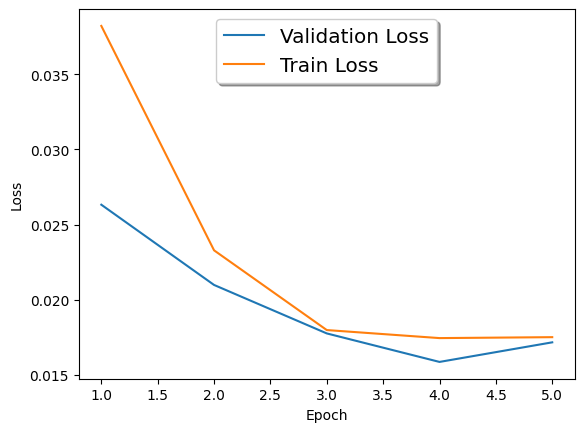

In [12]:
import matplotlib.pyplot as plt

epochs=range(1,6)
plt.plot(epochs,np.array(val_loss),label="Validation Loss")
plt.plot(epochs,np.array(train_loss),label="Train Loss")

legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
legend.get_frame()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

This function plots the low resolution, high resolution, and the model's output images:

In [9]:
def plot_images(high_res,low_res,high_resed):
    transform = transforms.ToPILImage()
    high_res = transform(high_res)
    print(high_resed.device)
    high_resed = transform(high_resed)
    low_res = transform(low_res)
    plt.figure(figsize=(6,10))
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(high_res)
    plt.figure(figsize=(6,10))
    plt.title('Model Output Image ', color = 'red', fontsize = 20)
    plt.imshow(high_resed)
    plt.figure(figsize=(6,10))
    plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_res)
    plt.show()

This code uses the above function to plot some of the outputs of the test set:

cuda:0


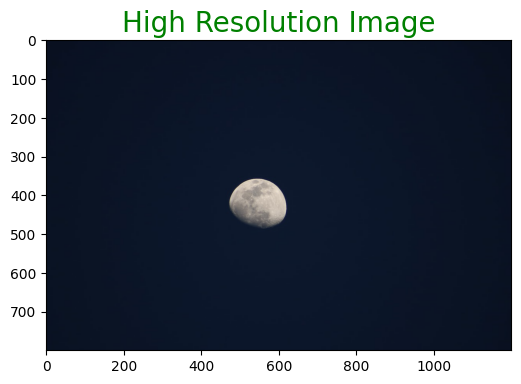

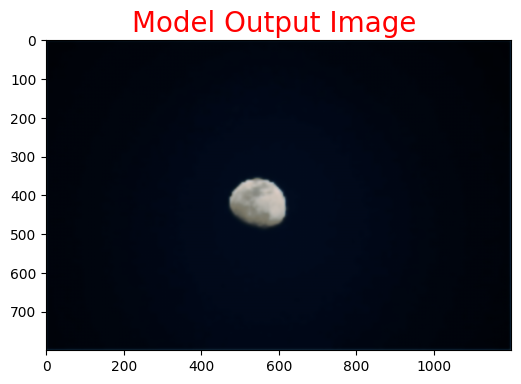

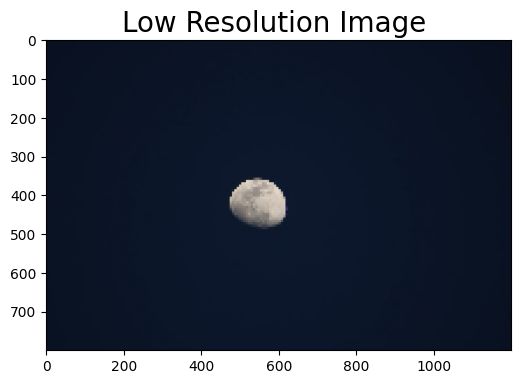

cuda:0


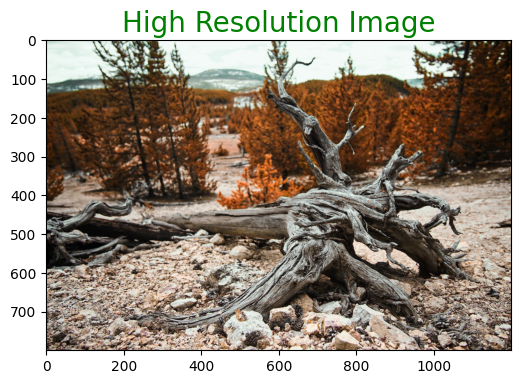

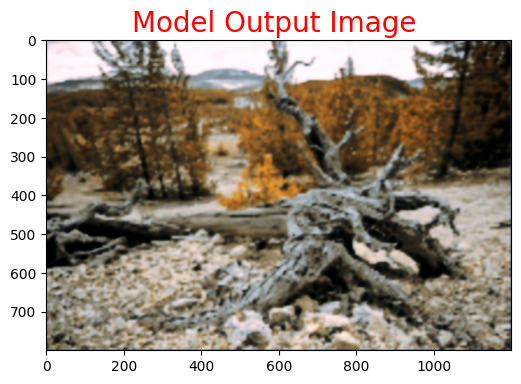

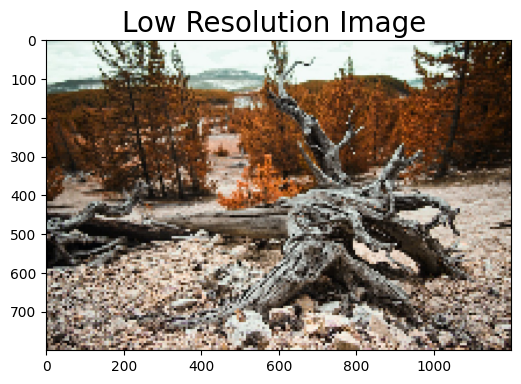

cuda:0


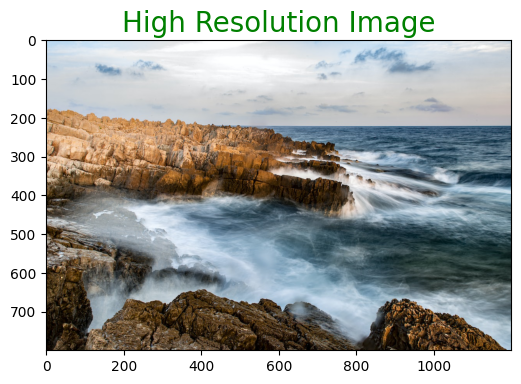

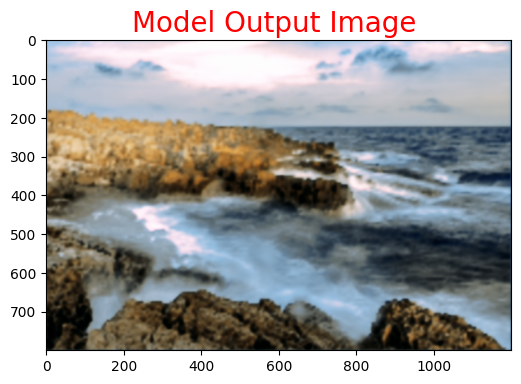

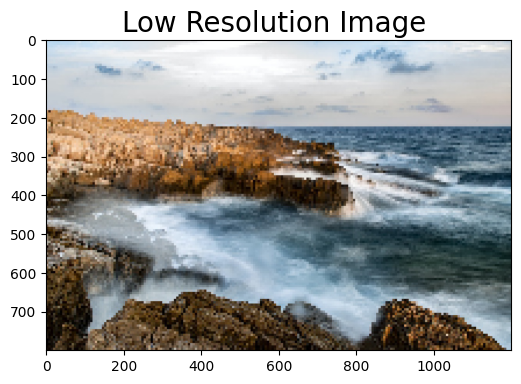

cuda:0


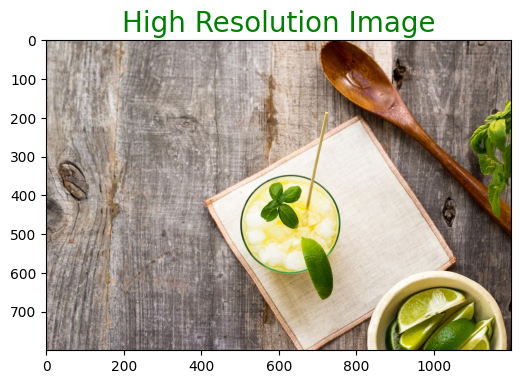

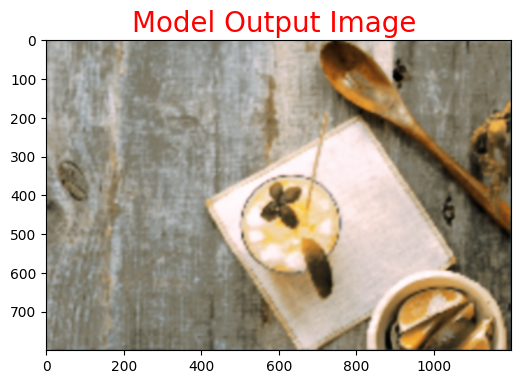

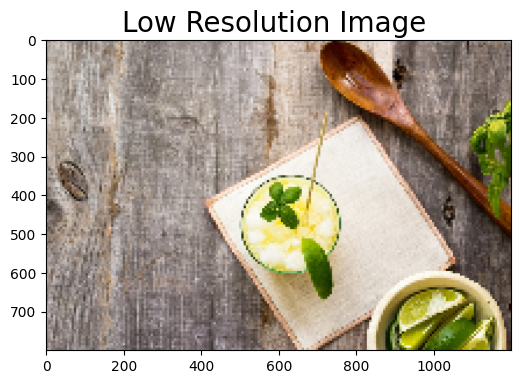

In [ ]:
for i in range(280//batch_size):
    with torch.no_grad():
        test_set_temp = ImageDataset(data[3492+i*batch_size:3492+(i+1)*batch_size], transform=data_transform, shuffle=True)
        if(len(test_set_temp)!=0):
            test_dataloader_temp = DataLoader(test_set_temp, batch_size=batch_size, shuffle=True, num_workers=2)
            input, target = next(iter(test_dataloader_temp))#[0],next(train_dataloader_temp)[0]
            inputs = input.to(device)
            targets = target.to(device)

            # Forward pass
            outputs = model(inputs)
            if(i%100==0):
                for j in range(4):
                    plot_images(targets[j],inputs[j],outputs[j])

We can see that the overall quality of the images have improved, even though number of epochs was only 5, which is a promising result.